# 1. SETTINGS

In [128]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import scipy.stats
import os
import time

In [129]:
# helper functions
import functions
from functions import *

In [130]:
# pandas options
pd.set_option('display.max_columns', None)

In [131]:
# white axis labeles
params = {'ytick.color' :     'w',
          'xtick.color' :     'w',
          'axes.labelcolor' : 'w',
          'axes.edgecolor' :  'w'}
plt.rcParams.update(params)

In [132]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [133]:
# garbage collection
import gc
gc.enable()

# 2. DATA PREPARATION

In [134]:
# import CSV
df = pd.read_csv('../data/data_v3.csv')
print(df.shape)

(500000, 13)


In [135]:
# target variable
target = 'fraud'

In [136]:
# partitioning
train = df[df[target].isnull() == False]
test  = df[df[target].isnull() == True]
print(train.shape)
print(test.shape)

(1879, 13)
(498121, 13)


In [137]:
# target variable
y = train.sort_values('id')[target]
test_ids = test['id']
del train, test

In [138]:
### IMPORT OOF PREDS

# list names
names = os.listdir('../oof_preds')

# preprocessing loop
for name in names:

    # load preds
    tmp_tr = pd.read_csv('../oof_preds/' + str(name))
    tmp_te = pd.read_csv('../submissions/' + str(name))

    # sort OOF preds by ID
    if 'id' in tmp_tr:
        tmp_tr = tmp_tr.sort_values('id')
        del tmp_tr['id']
    
    # rename columns
    tmp_tr.columns = [name]    
    tmp_te.columns = [name]    

    # cbind data
    if name == names[0]:     
        train = tmp_tr 
        test  = tmp_te
    else:
        train = pd.concat([train, tmp_tr], axis = 1)
        test  = pd.concat([test,  tmp_tr], axis = 1)
        
# display information
print('- Train shape:', train.shape)
print('- Test shape:', train.shape)

- Train shape: (1879, 8)
- Test shape: (1879, 8)


# 3. MODELING

In [139]:
# drop bad features
excluded_feats = ['id']
features = [f for f in train.columns if f not in excluded_feats]
print(train[features].shape)

(1879, 8)


In [140]:
### PARAMETERS

# settings
cores = 12
seed  = 999

# cross-validation
num_folds = 5
shuffle   = True

# muner of rounds
max_rounds = 600
stopping   = 600
verbose    = 200

# LGB parameters
lgb_params = {
    'boosting_type':     'gbdt',
    'objective':         'binary',
    'metrics':           'binary_logloss',
    'subsample':         0.9,
    'feature_fraction':  0.8,
    'lambda_l1':         0.1,
    'lambda_l2':         0.1,
    'min_split_gain':    0.01,
    'min_child_weight':  2,
    'min_child_samples': 20,
    'silent':            True,
    'verbosity':         -1,
    'learning_rate':     0.1,
    'max_depth':         7,
    'num_leaves':        70,
    'scale_pos_weight':  1,
    'n_estimators':      max_rounds,
    'nthread' :          cores,
    'random_state':      seed,
}

# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

In [141]:
# placeholders
clfs = []
valid_profit = np.zeros(num_folds) 
preds_test   = np.zeros(test.shape[0])
preds_oof    = np.zeros(train.shape[0])
importances  = pd.DataFrame()

In [142]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
           
    # train lightGBM
    print('Custom early stopping: select the best out of %.0f iterations...' % max_rounds)
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric           = prediction_reward, 
                  #eval_metric           = "logloss", 
                  #early_stopping_rounds = stopping,
                  verbose               = verbose)
    clfs.append(clf)
    
    # find the best iteration
    #best_iter = clf.best_iteration_
    best_iter = np.argmax(clf.evals_result_['valid_1']['profit']) + 1
    print('Best iteration is:')
    print('[' + str(best_iter) + ']   valid_1 profit: ' + 
          str(prediction_reward(val_y, clf.predict_proba(val_x, num_iteration = best_iter)[:, 1])[1].astype('int')))
       
    # predictions
    preds_oof[val_idx]    = clf.predict_proba(val_x, num_iteration = best_iter)[:, 1]
    valid_profit[n_fold]  = prediction_reward(val_y, preds_oof[val_idx])[1]
    preds_test           += clf.predict_proba(test[features], num_iteration = best_iter)[:, 1] / folds.n_splits 

    ## importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold'] = n_fold + 1
    importances = pd.concat([importances, fold_importance_df], axis = 0)
    
    # print performance
    print('----------------------')
    print('FOLD%2d: PROFIT = %.0f' % (n_fold + 1, valid_profit[n_fold]))
    print('----------------------')
    print('')
        
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    
# print overall performance    
cv_perf = np.sum(valid_profit)
print('----------------------')
print('TOTAL PROFIT = %.0f' % cv_perf)
print('----------------------')

Custom early stopping: select the best out of 600 iterations...
[200]	training's binary_logloss: 0.00873936	training's profit: 320	valid_1's binary_logloss: 0.0226916	valid_1's profit: -20
[400]	training's binary_logloss: 0.00772349	training's profit: 355	valid_1's binary_logloss: 0.0228873	valid_1's profit: -20
[600]	training's binary_logloss: 0.00725142	training's profit: 355	valid_1's binary_logloss: 0.0229558	valid_1's profit: -30
Best iteration is:
[14]   valid_1 profit: 85
----------------------
FOLD 1: PROFIT = 85
----------------------

Custom early stopping: select the best out of 600 iterations...
[200]	training's binary_logloss: 0.00813902	training's profit: 370	valid_1's binary_logloss: 0.040977	valid_1's profit: 65
[400]	training's binary_logloss: 0.00750907	training's profit: 380	valid_1's binary_logloss: 0.0419558	valid_1's profit: 65
[600]	training's binary_logloss: 0.00737225	training's profit: 380	valid_1's binary_logloss: 0.0417933	valid_1's profit: 65
Best iteration

In [143]:
##### RECHECK PROFIT  
prediction_reward(y, preds_oof)


###### TRACKING RESULTS

# stacking 8 models: 390 = 85 + 65 + 45 + 105 + 90

('profit', 390.0, True)

- optimal cutoff = 0.5000
- optimal profit = 390.0000


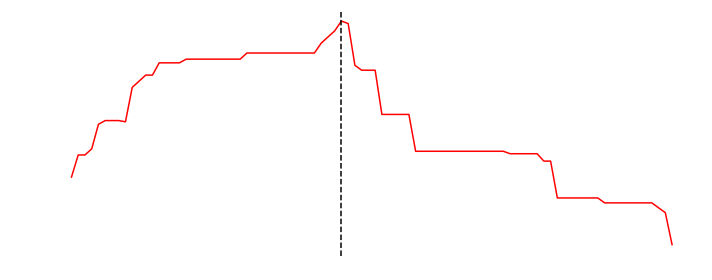

In [144]:
##### OPTIMIZE CUTOFF

# set step
step = 100

# search
cutoffs = []
profits = []
for i in range(0, step):
    cutoffs.append(i / step)
    profits.append(recompute_reward(y, preds_oof, cutoff = cutoffs[i]))
        
# results
plt.figure(figsize = (10,4))
sns.lineplot(x = cutoffs[10:step], y = profits[10:step], color = 'red')
plt.tight_layout()
plt.axvline(x = cutoffs[np.argmax(profits)], color = 'black', linestyle = '--')
print('- optimal cutoff = %.4f' % cutoffs[np.argmax(profits)])
print('- optimal profit = %.4f' % profits[np.argmax(profits)])

# 4. SUBMISSION

In [145]:
# file name
model = 'stack_8'
perf  = str(round(cv_perf, 0).astype('int'))
name  = model + '_' + perf

In [146]:
# check submission
sub = pd.DataFrame({'id': test_ids, 'fraud': preds_test})
sub['fraud'] = np.round(sub['fraud']).astype('int')
sub.head()

,id,fraud
1879,unlab_0,0
1880,unlab_1,0
1881,unlab_2,0
1882,unlab_3,0
1883,unlab_4,0


In [147]:
# export submission
sub = sub[['fraud']]
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.shape

(498121, 1)

In [148]:
# check correlation with previous submission
prev_sub = pd.read_csv('../submissions/lgb_v8_375.csv')
cor = np.sum(prev_sub[target] == sub.reset_index()[target]) / len(sub)
print("Share of the same predictions: " + str(np.round(cor, 6)))

Share of the same predictions: 0.957422
